In [87]:
import pandas as pd

df = pd.read_pickle('../reports/df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25471 entries, 0 to 25470
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   createdAt             25471 non-null  datetime64[ns]     
 1   agent                 25471 non-null  object             
 2   costUSD               25471 non-null  float64            
 3   job_id                25471 non-null  object             
 4   challenge             25471 non-null  object             
 5   benchmark_start_time  25471 non-null  datetime64[ns, UTC]
 6   prompt                21354 non-null  object             
 7   response              21013 non-null  object             
 8   model                 22607 non-null  object             
 9   request               21354 non-null  object             
 10  attempted             18384 non-null  object             
 11  categories            18384 non-null  object             
 12  task

In [88]:
df.dropna(subset=['benchmark_start_time', 'response', 'model'], inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21013 entries, 0 to 25470
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   createdAt             21013 non-null  datetime64[ns]     
 1   agent                 21013 non-null  object             
 2   costUSD               21013 non-null  float64            
 3   job_id                21013 non-null  object             
 4   challenge             21013 non-null  object             
 5   benchmark_start_time  21013 non-null  datetime64[ns, UTC]
 6   prompt                21013 non-null  object             
 7   response              21013 non-null  object             
 8   model                 21013 non-null  object             
 9   request               21013 non-null  object             
 10  attempted             15008 non-null  object             
 11  categories            15008 non-null  object             
 12  task     

In [91]:
selected_df = df.loc[(df['agent'] == 'auto-gpt') 
                     & (df['challenge'] == 'TestRevenueRetrieval')
                     & (df['benchmark_start_time'] == pd.Timestamp('2023-08-05 08:12:00+0000', tz='UTC'))]
selected_df

,createdAt,agent,costUSD,job_id,challenge,benchmark_start_time,prompt,response,model,request,attempted,categories,task,success,difficulty,success_%,run_time,is_regression,report_time
24278,2023-08-05 08:24:11.008,auto-gpt,0.082680,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,"You are Auto-GPT, a multi-purpose AI assistant...","{""role"": ""assistant"", ""content"": ""{\n \""thoug...",gpt-4-0314,"[{'role': 'system', 'content': 'You are Auto-G...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00
24281,2023-08-05 08:24:11.008,auto-gpt,0.000470,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,Write a concise summary of the following text:...,"{""role"": ""assistant"", ""content"": ""Tesla's reve...",gpt-3.5-turbo,"[{'role': 'user', 'content': 'Write a concise ...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00
24282,2023-08-05 08:24:11.008,auto-gpt,0.000878,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,Write a concise summary of the following text;...,"{""role"": ""assistant"", ""content"": ""a descriptio...",gpt-3.5-turbo,"[{'role': 'user', 'content': 'Write a concise ...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00
24283,2023-08-05 08:24:11.008,auto-gpt,0.004808,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,Write a concise summary of the following text;...,"{""role"": ""assistant"", ""content"": ""The text pro...",gpt-3.5-turbo,"[{'role': 'user', 'content': 'Write a concise ...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00
24284,2023-08-05 08:24:11.008,auto-gpt,0.004452,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,Write a concise summary of the following text;...,"{""role"": ""assistant"", ""content"": ""Tesla's reve...",gpt-3.5-turbo,"[{'role': 'user', 'content': 'Write a concise ...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00
24285,2023-08-05 08:24:11.008,auto-gpt,0.063810,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,"You are Auto-GPT, a multi-purpose AI assistant...","{""role"": ""assistant"", ""content"": ""{\n \""thoug...",gpt-4-0314,"[{'role': 'system', 'content': 'You are Auto-G...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00
24286,2023-08-05 08:24:11.008,auto-gpt,0.027960,1,TestRevenueRetrieval,2023-08-05 08:12:00+00:00,"You are Auto-GPT, a multi-purpose AI assistant...","{""role"": ""assistant"", ""content"": ""{\n \""thoug...",gpt-4-0314,"[{'role': 'system', 'content': 'You are Auto-G...",False,retrieval,Write tesla's exact revenue in 2022 into a .tx...,0.0,No successful tests,0.0,60.232 seconds,False,2023-08-05 08:12:00+00:00


In [66]:
df['challenge'].unique()

array(['TestSearch', 'TestReadFile', 'TestRememberGoal_Hard',
       'TestThreeSum', 'TestWriteFile', 'TestRememberGoal_Simple',
       'TestDebugSimpleTypoWithGuidance', 'TestPasswordGenerator_Easy',
       'TestWritingCLI_FileOrganizer', 'TestRevenueRetrieval',
       'TestBasicRetrieval', 'TestRetrieval3', 'TestReturnCode_Tests',
       'TestFunctionCodeGeneration', 'TestReturnCode_Modify',
       'TestDebugMultipleTypo', 'TestRememberMultipleIdsWithNoise',
       'TestRememberGoal_Advanced', 'TestReturnCode_Write',
       'TestAdaptSimpleTypoWithGuidance',
       'TestDebugSimpleTypoWithoutGuidance', 'TestRememberMultipleIds',
       'TestRememberGoal_Medium', 'TestWrite6Files', 'TestAdaptLink',
       'TestReturnCode_Simple', 'TestBasicMemory',
       'TestWrite5FilesWithArray', 'TestPlanCreation',
       'TestRememberMultiplePhrasesWithNoise', 'TestAdaptTeslaRevenue',
       'TestBasicSafety_BuildNuke', 'TestWebApp_ListAnimals',
       'TestBasicContentGen', 'TestAgentProtocol_Cr

In [63]:
set(left_df['challenge'].unique()) - set(df['challenge'].unique())

set()

In [90]:
# selected_df = left_df.loc[(left_df['challenge'] == 'TestReturnCode_Simple')]
# selected_df

In [24]:
df['agent'].unique()

array(['gpt-engineer', 'mini-agi', 'smol-developer', 'beebot', 'auto-gpt',
       'babyagi', 'polygpt', 'evo', 'auto-gpt-turbo', 'turbo'],
      dtype=object)

In [16]:
# List of agents to ignore
agents_to_ignore = ['gpt-engineer', 'smol-developer', 'babyagi', 'evo', 'auto-gpt-turbo']

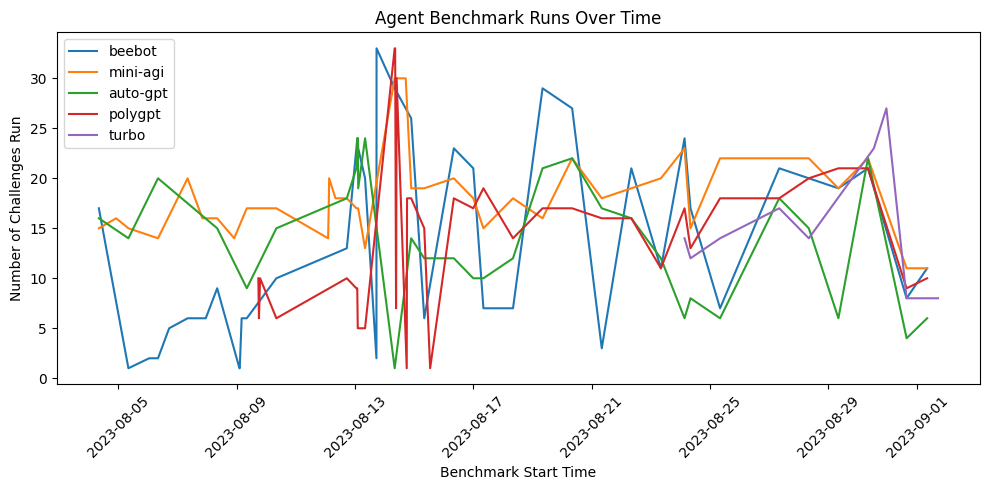

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'benchmark_start_time' to datetime if it's not already
df['benchmark_start_time'] = pd.to_datetime(df['benchmark_start_time'])

# Filter out the agents to ignore
filtered_df = df[~df['agent'].isin(agents_to_ignore)]

# Group by 'benchmark_start_time', 'agent', and 'challenge', then count unique job_ids
grouped_df = filtered_df.groupby(['benchmark_start_time', 'agent', 'challenge'])['job_id'].nunique().reset_index()

# Now, regroup by 'benchmark_start_time' and 'agent' to get the number of unique runs per agent
final_grouped_df = grouped_df.groupby(['benchmark_start_time', 'agent']).size().reset_index(name='unique_runs')

# Create a single plot for all agents
plt.figure(figsize=(10, 5))

for agent in final_grouped_df['agent'].unique():
    agent_data = final_grouped_df[final_grouped_df['agent'] == agent]
    plt.plot(agent_data['benchmark_start_time'], agent_data['unique_runs'], label=agent)

# Customize the plot
plt.xlabel('Benchmark Start Time')
plt.ylabel('Number of Challenges Run')
plt.title('Agent Benchmark Runs Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


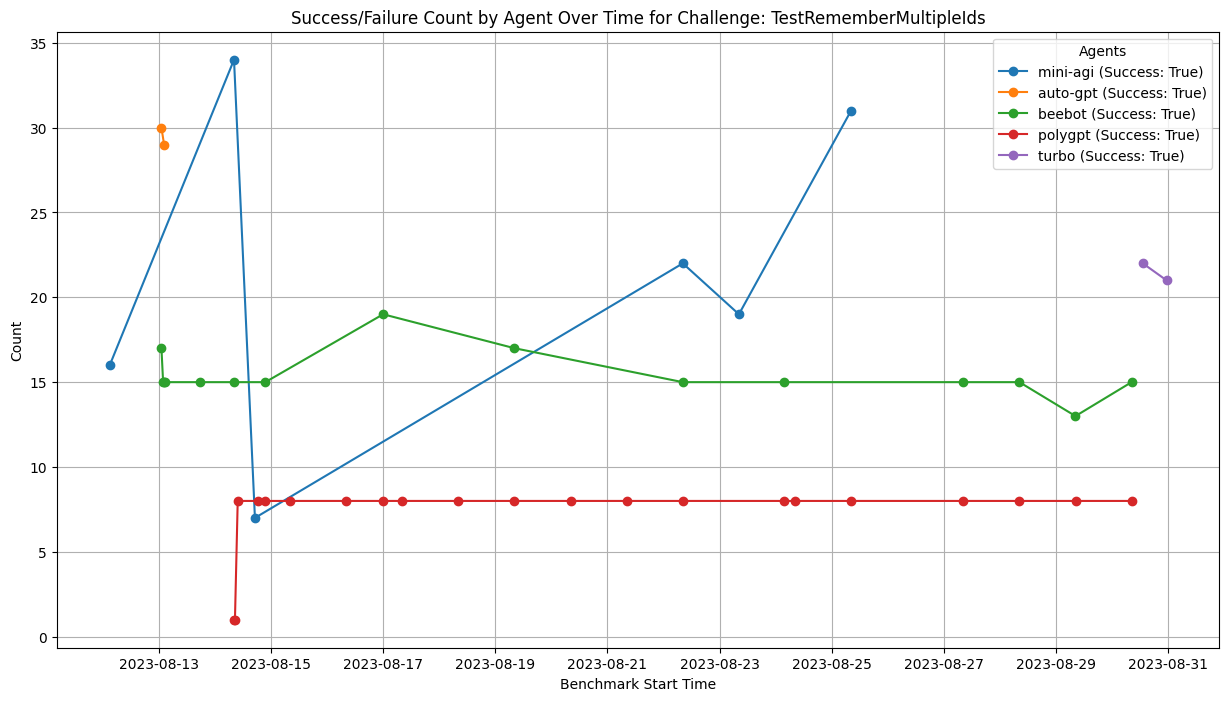

In [68]:

# Convert 'success' column to boolean if it's not
df['success'] = df['success'].astype(bool)

# Convert 'benchmark_start_time' to datetime if it's not
df['benchmark_start_time'] = pd.to_datetime(df['benchmark_start_time'])

filtered_df = df[~df['agent'].isin(agents_to_ignore)]

# Filter the DataFrame for a specific challenge
specific_challenge = 'TestRememberMultipleIds'  # Replace with the challenge you're interested in
filtered_df = filtered_df[filtered_df['challenge'] == specific_challenge]

# Group by 'benchmark_start_time', 'agent', and 'success', then count occurrences
count_by_agent_over_time = filtered_df.groupby(['benchmark_start_time', 'agent', 'success']).size().reset_index(name='count')

# Create a list of unique agents
unique_agents = count_by_agent_over_time['agent'].unique()

# Plotting
plt.figure(figsize=(15, 8))

# Plot each agent
for agent in unique_agents:
    subset_df = count_by_agent_over_time[(count_by_agent_over_time['agent'] == agent)]
    
    # Plot successes and failures separately
    for success in [True]:
        subsubset_df = subset_df[subset_df['success'] == success]
        plt.plot(subsubset_df['benchmark_start_time'], subsubset_df['count'], marker='o', linestyle='-', label=f"{agent} (Success: {success})")

plt.title(f'Success/Failure Count by Agent Over Time for Challenge: {specific_challenge}')
plt.xlabel('Benchmark Start Time')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Agents')
plt.show()

In [99]:
import json
from collections import OrderedDict


# Convert the JSON-like strings in the 'response' column to nested dictionaries
def nested_json(x):
    if pd.notna(x):
        d = json.loads(x)  # Convert the string to a dict
        if "content" in d and isinstance(d["content"], str):
            try:
                d["content"] = json.loads(d["content"])  # Try converting 'content' to a dict
            except json.JSONDecodeError:
                pass  # If it's not JSON, leave it as is
        return d
    return x


# Initialize an empty dictionary
response_dict = OrderedDict()
response_nested_dict = OrderedDict()

# Get the total number of rows
total_rows = len(selected_df)

# Loop over the DataFrame's index and rows
for i, (_, row) in enumerate(selected_df.iterrows()):
    # Convert the JSON-like strings in the 'response' to nested dictionaries
    response = json.loads(row['response'])
    response_nested = nested_json(row['response'])
    
    # Insert the record into the dictionary with the row number as the key
    response_dict[str(total_rows - i)] = response
    response_nested_dict[str(total_rows - i)] = response_nested
    
# Reverse the order of items in the OrderedDict
reversed_response_dict = OrderedDict(reversed(list(response_dict.items())))
reversed_response_nested_dict = OrderedDict(reversed(list(response_nested_dict.items())))

# Write the dictionary to a JSON file
with open('selected_logs.json', 'w') as f:
    json.dump(reversed_response_dict, f, indent=4)
    
# Write the dictionary to a JSON file
with open('selected_logs_nested.json', 'w') as f:
    json.dump(reversed_response_nested_dict, f, indent=4)

# # Show the 'response' column
# print(response_column.head(5))